# UMI-DSBseq Consensus Sequence Analysis WorkFlow

In [ ]:
import Bio
from Bio import SeqIO
from Bio import Align
from Bio import pairwise2
from Bio.SubsMat import MatrixInfo as matlist
from Bio.pairwise2 import format_alignment
from io import StringIO
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
from matplotlib import cm
import copy
from collections import Counter
import glob
matrix = matlist.blosum62
from Bio.Seq import Seq
from tqdm import tqdm
import pickle
import math
from Bio.Restriction import *

### Functions
#### Mut_col functions for analyzing UMI-DSBseq reads following alignment
    1. Mut_col_reverse_guide_only: in the case that the primer is oriented correctly, but the sgRNA is in reverse
    2. Mut_col_reverse: in the case that both the primer and sgRNA are in reverse
    3. Mut_col_Forward: in the case that the primer and sgRNA are oriented correctly


In [2]:
### in the case that the primer is oriented correctly, but the sgRNA is in reverse
def Mut_col_reverse_guide_only(DFW):
    DFW['Mut name'] = ""
    DFW['position'] = ""
    DFW['Left_MH'] = ""
    DFW['Right_MH'] = ""
    for row in DFW.iterrows():
        wt = str(row[1].loc['WT Sequence'])
        rgen = str(row[1].loc['RGEN Treated Sequence'])
        guide = main_df.loc[name,'Guide sequence']
        reference = main_df.loc[name,'WT_REF']

        amplicon = Seq(wt)
        rgen_amplicon = Seq(rgen)
        break_site = amplicon.find(guide)+len(guide)-3
        pam_side = amplicon[break_site:]
        guide_side = amplicon[:break_site]
        if row[1].loc['Type'] == 'Extended DSB': 
            if len(rgen) > 50:
                left_end = len(rgen)-50
                mut_name = rgen[:left_end]
                position = 50-left_end
                idx = f'{50-left_end}'
                    #df.loc[index,'Mut name'] = f'+{mut_name}'
                if wt[position:50] == mut_name:
                    DFW.loc[row[0],'Type'] = 'guide_side DSB'
            DFW.loc[row[0],'Mut name'] = f'+{mut_name}'
            DFW.loc[row[0],'position'] = f'{idx}'
            #DFW.loc[row[0],'Mut name'] = f'NaN'

        if row[1].loc['Type'] == 'Resected DSB':
            if len(rgen) < 50:
                DFW.loc[row[0],'Type'] = 'PAM_side DSB'
                left_end = 100-len(rgen)
                mut_name = wt[50:left_end]
                idx = f'{left_end}'
            DFW.loc[row[0],'position'] = f'{idx}'
            DFW.loc[row[0],'Mut name'] = f'-{mut_name}'
            #DFW.loc[row[0],'Mut name'] = f'NaN'

        if row[1].loc['Type'] == 'Del':
            mut_name = ""
            for le in range(min([len(wt),len(rgen)])):
                if wt[le] != rgen[le] and rgen[le] == '-' :
                    mut_name += wt[le]  
            ###setting the INDEL length ##
            indel_len = len(mut_name)

            ###left end of the INDL ###
            left_end = Seq(rgen).find('-')

            ####right end of the break ###
            right_end = left_end + indel_len-1

            #extract sides of each indel
            rev_mut_name = mut_name[::-1]
            left_bound = wt[left_end-1]
            right_bound = wt[right_end+1]

            leftmm = wt[left_end-1] == mut_name[-1]
            rightmm = wt[right_end+1] == mut_name[0]
            if leftmm and rightmm == False:
                DFW.loc[row[0],'Right_MH'] = ''
                DFW.loc[row[0],'Left_MH'] = ''
            if leftmm or rightmm == True:
                DFW.loc[row[0],'Type'] = 'MH_Del'
                Right_MH = ""
                MH_Name = ""
                Left_MH = ""
                right_side = wt[right_end+1:]
                left_side = wt[:left_end][::-1]
                left_side_rev = wt[:left_end]

                for le in range(len(mut_name)):
                    if right_side[le] == mut_name[le]:
                        Right_MH += right_side[le]
                    else:
                        break

                DFW.loc[row[0],'Right_MH'] = f'{Right_MH}'           

                for le in range(len(mut_name)):
                    if left_side[le] == mut_name[-(le+1)]:
                        Left_MH += mut_name[-(le+1)]
                    else:
                        break
                    #print(Left_MH) 
                DFW.loc[row[0],'Left_MH'] = f'{Left_MH}'
            left_position_border = left_end-1
            right_position_border = right_end+1
            idx = f'{left_position_border}'+'_'+f'{right_position_border}'
                #x = left_end - 1
            DFW.loc[row[0],'position'] = f'{idx}'            
            DFW.loc[row[0],'Mut name'] = f'-{mut_name}'
        else:
            DFW.loc[row[0],'Right_MH'] = ''
            DFW.loc[row[0],'Left_MH'] = ''

        if row[1].loc['Type'] == 'Perfect DSB':
            wt = row[1].loc['WT Sequence']
            rgen = row[1].loc['RGEN Treated Sequence']
            #left_end = Seq(rgen).find('-')
            #idx = f'I{left_end}' 
            if len(rgen) == 50:
                mut_name = 'precise'
                left_end = len(rgen)
                idx = f'{left_end}'
            DFW.loc[row[0],'position'] = f'{idx}'
            DFW.loc[row[0],'Mut name'] = f'{mut_name}'
        
        if row[1].loc['Type'] == 'Ins':
            mut_name = ""
            for le in range(min([len(wt),len(rgen)])):
                if wt[le] != rgen[le] and wt[le] == '-' :
                    mut_name += rgen[le]

            ###setting the INDEL length ##
            indel_len = len(mut_name)

            ###left end of the INDL ###
            left_end = Seq(wt).find('-')

            idx = f'{left_end}'
            #x = left_end - 1
            DFW.loc[row[0],'position'] = f'{left_end}'
            DFW.loc[row[0],'Mut name'] = f'+{mut_name}'
            DFW.loc[row[0],'Right_MH'] = ''
            DFW.loc[row[0],'Left_MH'] = ''
    return(DFW)

In [3]:
### in the case that both the primer and sgRNA are in reverse
def Mut_col_reverse(DFW):
    DFW['Mut name'] = ""
    DFW['position'] = ""
    DFW['Left_MH'] = ""
    DFW['Right_MH'] = ""
    for row in DFW.iterrows():
        wt = str(row[1].loc['WT Sequence'])
        rgen = str(row[1].loc['RGEN Treated Sequence'])
        guide = main_df.loc[name,'Guide sequence']
        reference = main_df.loc[name,'WT_REF']

        amplicon = Seq(wt)
        rgen_amplicon = Seq(rgen)

        amplicon = amplicon.reverse_complement()
        temp_rgen = Seq(rgen)
        rgen = str(temp_rgen.reverse_complement())
        temp_wt = Seq(wt)
        wt = str(temp_wt.reverse_complement())

        break_site = amplicon.find(guide)+len(guide)-3
        pam_side = amplicon[break_site:]
        guide_side = amplicon[:break_site]

        if row[1].loc['Type'] == 'Extended DSB': 
            if len(rgen) > 50:
                left_end = len(rgen)-50
                mut_name = rgen[:left_end]
                position = 50-left_end
                idx = f'{50-left_end}'
                if wt[position:50] == mut_name:
                    DFW.loc[row[0],'Type'] = 'guide_side DSB'
            DFW.loc[row[0],'Mut name'] = f'+{mut_name}'
            DFW.loc[row[0],'position'] = f'{idx}'

        if row[1].loc['Type'] == 'Resected DSB':
            if len(rgen) < 50:
                DFW.loc[row[0],'Type'] = 'PAM_side DSB'
                left_end = 100-len(rgen)
                mut_name = wt[50:left_end]
                idx = f'{left_end}'
            DFW.loc[row[0],'position'] = f'{idx}'
            DFW.loc[row[0],'Mut name'] = f'-{mut_name}'

        if row[1].loc['Type'] == 'Del':
            mut_name = ""
            for le in range(min([len(wt),len(rgen)])):
                if wt[le] != rgen[le] and rgen[le] == '-' :
                    mut_name += wt[le]  
            ###setting the INDEL length ##
            indel_len = len(mut_name)

            ###left end of the INDL ###
            left_end = Seq(rgen).find('-')

            ####right end of the break ###
            right_end = left_end + indel_len-1

            #extract sides of each indel
            rev_mut_name = mut_name[::-1]
            left_bound = wt[left_end-1]
            right_bound = wt[right_end+1]

            leftmm = wt[left_end-1] == mut_name[-1]
            rightmm = wt[right_end+1] == mut_name[0]
            if leftmm and rightmm == False:
                DFW.loc[row[0],'Right_MH'] = ''
                DFW.loc[row[0],'Left_MH'] = ''
            if leftmm or rightmm == True:
                DFW.loc[row[0],'Type'] = 'MH_Del'
                Right_MH = ""
                MH_Name = ""
                Left_MH = ""
                right_side = wt[right_end+1:]
                left_side = wt[:left_end][::-1]
                left_side_rev = wt[:left_end]
                for le in range(len(mut_name)):
                    if right_side[le] == mut_name[le]:
                        Right_MH += right_side[le]
                    else:
                        break
                DFW.loc[row[0],'Right_MH'] = f'{Right_MH}'           
                for le in range(len(mut_name)):
                    if left_side[le] == mut_name[-(le+1)]:
                        Left_MH += mut_name[-(le+1)]
                    else:
                        break
                DFW.loc[row[0],'Left_MH'] = f'{Left_MH}'
            left_position_border = left_end-1
            right_position_border = right_end+1
            idx = f'{left_position_border}'+'_'+f'{right_position_border}'
            DFW.loc[row[0],'position'] = f'{idx}'            
            DFW.loc[row[0],'Mut name'] = f'-{mut_name}'
        else:
            DFW.loc[row[0],'Right_MH'] = ''
            DFW.loc[row[0],'Left_MH'] = ''
        if row[1].loc['Type'] == 'Perfect DSB':
            wt = row[1].loc['WT Sequence']
            rgen = row[1].loc['RGEN Treated Sequence']
            if len(rgen) == 50:
                mut_name = 'precise'
                left_end = len(rgen)
                idx = f'{left_end}'
            DFW.loc[row[0],'position'] = f'{idx}'
            DFW.loc[row[0],'Mut name'] = f'{mut_name}'
        if row[1].loc['Type'] == 'Ins':
            mut_name = ""
            for le in range(min([len(wt),len(rgen)])):
                if wt[le] != rgen[le] and wt[le] == '-' :
                    mut_name += rgen[le]
            ###setting the INDEL length ##
            indel_len = len(mut_name)
            ###left end of the INDL ###
            left_end = Seq(wt).find('-')
            idx = f'{left_end}'
            DFW.loc[row[0],'position'] = f'{left_end}'
            DFW.loc[row[0],'Mut name'] = f'+{mut_name}'
            DFW.loc[row[0],'Right_MH'] = ''
            DFW.loc[row[0],'Left_MH'] = ''
    return(DFW)

In [4]:
### in the case that the primer and sgRNA are oriented correctly
def Mut_col_Forward(DFW):
    DFW['Mut name'] = ""
    DFW['position'] = ""
    DFW['Left_MH'] = ""
    DFW['Right_MH'] = ""
    for row in DFW.iterrows():
        wt = row[1].loc['WT Sequence']
        rgen = row[1].loc['RGEN Treated Sequence']
        guide = main_df.loc[name,'Guide sequence']
        reference = main_df.loc[name,'WT_REF']
        wt=str(wt)
        rgen=str(rgen)
        amplicon = Seq(wt)
        rgen_amplicon = Seq(rgen)

        break_site = amplicon.find(guide)+len(guide)-3
        pam_side = amplicon[break_site:]
        guide_side = amplicon[:break_site]

        if row[1].loc['Type'] == 'Perfect DSB':
            if len(rgen) == 50:
                mut_name = 'precise'
                left_end = len(rgen)-1
                idx = f'{left_end}'
            DFW.loc[row[0],'position'] = f'{idx}'
            DFW.loc[row[0],'Mut name'] = f'{mut_name}'

        if row[1].loc['Type'] == 'Extended DSB': 
            mut_name = ""
            if len(rgen) > 50:
                left_end = len(rgen)
                mut_name = rgen[50:]
                position = left_end
                if wt[50:position] == mut_name:
                    DFW.loc[row[0],'Type'] = 'PAM_side DSB'
                left_position_border = left_end-1
                idx = f'{left_position_border}'
            DFW.loc[row[0],'Mut name'] = f'+{mut_name}'
            DFW.loc[row[0],'position'] = f'{idx}'

        if row[1].loc['Type'] == 'Resected DSB':
            mut_name = ""                
            if len(rgen) < 50:
                DFW.loc[row[0],'Type'] = 'guide_side DSB'
                left_end = len(rgen)
                mut_name = wt[left_end:50]
                left_position_border = left_end-1
                idx = f'{left_position_border}'
                
            DFW.loc[row[0],'position'] = f'{idx}'
            DFW.loc[row[0],'Mut name'] = f'-{mut_name}'
            
        if row[1].loc['Type'] == 'Del':
            mut_name = ""
            for le in range(min([len(wt),len(rgen)])):
                if wt[le] != rgen[le] and rgen[le] == '-' :
                    mut_name += wt[le]  
            ###setting the INDEL length ##
            indel_len = len(mut_name)

            ###left end of the INDL ###
            left_end = Seq(rgen).find('-')

            ####right end of the break ###
            right_end = left_end + indel_len-1

            #extract sides of each indel
            rev_mut_name = mut_name[::-1]
            left_bound = wt[left_end-1]
            right_bound = wt[right_end+1]

            leftmm = wt[left_end-1] == mut_name[-1]
            rightmm = wt[right_end+1] == mut_name[0]
            if leftmm and rightmm == False:
                DFW.loc[row[0],'Right_MH'] = ''
                DFW.loc[row[0],'Left_MH'] = ''
            if leftmm or rightmm == True:
                DFW.loc[row[0],'Type'] = 'MH_Del'
                Right_MH = ""
                MH_Name = ""
                Left_MH = ""
                right_side = wt[right_end+1:]
                left_side = wt[:left_end][::-1]
                left_side_rev = wt[:left_end]

                for le in range(len(mut_name)):
                    if right_side[le] == mut_name[le]:
                        Right_MH += right_side[le]
                    else:
                        break

                DFW.loc[row[0],'Right_MH'] = f'{Right_MH}'           

                for le in range(len(mut_name)):
                    if left_side[le] == mut_name[-(le+1)]:
                        Left_MH += mut_name[-(le+1)]
                    else:
                        break
                DFW.loc[row[0],'Left_MH'] = f'{Left_MH}'
            left_position_border = left_end-1
            right_position_border = right_end+1
            idx = f'{left_position_border}'+'_'+f'{right_position_border}'
            DFW.loc[row[0],'position'] = f'{idx}'            
            DFW.loc[row[0],'Mut name'] = f'-{mut_name}'
        else:
            DFW.loc[row[0],'Right_MH'] = ''
            DFW.loc[row[0],'Left_MH'] = ''
        
        if row[1].loc['Type'] == 'Ins':
            mut_name = ""
            for le in range(min([len(wt),len(rgen)])):
                if wt[le] != rgen[le] and wt[le] == '-' :
                    mut_name += rgen[le]

            ###setting the INDEL length ##
            indel_len = len(mut_name)

            ###left end of the INDL ###
            left_end = Seq(wt).find('-')

            idx = f'{left_end}'
            DFW.loc[row[0],'position'] = f'{left_end}'
            DFW.loc[row[0],'Mut name'] = f'+{mut_name}'
            DFW.loc[row[0],'Right_MH'] = ''
            DFW.loc[row[0],'Left_MH'] = ''
    return(DFW)

In [5]:
def sample_data_from_xlsx(fname):
    df_samp = pd.read_excel(fname)
    df_samp = df_samp.set_index('Sample Name')### generating DF from elsx file form curnt dir 
    return(df_samp)  

In [6]:
def Calculate_average(data):
    #Calculate average based on ordered duplicates
    data = data.T
    avg_NHEJ = data.groupby(np.arange(len(data.index))//2).mean() 
    avg_NHEJ.index = avg_names
    return(avg_NHEJ)
avg_names = [0,6,12,24,36,48,72]

## 1.User Input
    name of target (target_name) - for naming output
    directory containing joined-fastqs and Sample_data.xlxs (my_dir), 
    Sample_data.xlxs file: must be placed in fastq-join folder
        Required columns, rows for each sample in time-course:
             'library name': name of fastq-join file
             'Sample Name': name of sample
             'Guide sequence': sgRNA 20bp sequence (no PAM)
             'Amplicon sequence': expected sequence of wt intact molecule (primer--> restriction site:
             'forward_primer': sequene of target-specific amplification primer
             'restricted_end': expected 5 bp end of amplicon at end-repaired restrictioin site 
#### EXAMPLE
     target_name = 'Psy1'
     restricted_end = 'GTCCG'#enter 5bp end of amplicon at the restriction site
     imprecise_end='' #enter sequence for direct filtering
     my_dir = '/fastq_join/'
## 2. Create 100bp reference sequence
    reads in Sample_data.xlxs file
    extracts reference sequence from WT_ref (50bp to each side of DSB using Guide sequence and Amplicon sequence)
## 3. Convert fastq-join to table of id, read sequence, wt sequence 
    Parse fastq-joined files using SeqIO, make simple table for further processessing

In [12]:
target_name = input('''ENTER Name of target
# will be used for naming output \n''')
imprecise_end = input('''ENTER last 5bp of sequence to filter OUT  - press enter if none - 
# will be used for filtering of desired sequence \n''')
my_dir = input('''ENTER YOUR FASTQ-JOIN DIRECTORY
# ...PATH_TO/fastq-join/\n''')
save_dir = input('''ENTER PATH to DIRECTORY for saving
# ...PATH_TO/save_dir/\n''')

os.chdir(my_dir)
main_df = sample_data_from_xlsx("Sample_data.xlsx")
time_names = list(main_df.index)
for idx in time_names:
    if main_df.loc[idx,'Guide sequence'] not in main_df.loc[idx,'Amplicon sequence'] :
        seq_rev = Seq(main_df.loc[idx,'Amplicon sequence'] ).reverse_complement()
        main_df.loc[idx,'Amplicon sequence']  = seq_rev
    main_df.loc[idx,'Guide sequence'] = main_df.loc[idx,'Guide sequence'].upper()
    main_df.loc[idx,'Amplicon sequence'] = main_df.loc[idx,'Amplicon sequence'].upper()
    L_end = (main_df.loc[idx,'Amplicon sequence'].find(main_df.loc[idx,'Guide sequence'])+len(main_df.loc[idx,'Guide sequence'])-3 - 50 )    
    if L_end < 0: 
        L_end = 0
    R_end = ( main_df.loc[idx,'Amplicon sequence'].find(main_df.loc[idx,'Guide sequence'])+len(main_df.loc[idx,'Guide sequence'])-3 + 50)
    main_df.loc[idx,'WT_REF'] =  main_df.loc[idx,'Amplicon sequence'][L_end:R_end]   
    if type(main_df.loc[idx,'WT_REF']) != Bio.Seq.Seq:
        main_df.loc[idx,'WT_REF'] = Seq(main_df.loc[idx,'WT_REF'])
    print(f"{idx} -->len {len(main_df.loc[idx,'WT_REF'] )}")
    
dict_of_all_samples = {}
for idx in time_names:
    time = str(main_df.loc[idx,'library name'])
    file_name =f"{time}.join.fastq"
    file_path = my_dir+file_name
    table = pd.DataFrame(columns=['records','seq_id','seq'])#creates empty table with columns 
    records = list(SeqIO.parse(file_name, "fastq"))#parse the fastq one by one
    print("Starting analysis of %s ..." % time)
    print("    Processing %i Reads" % len(records))
    table.loc[:,'records'] = records
    table.loc[:, 'seq_id'] = table.records.map(lambda  x: x.id)
    table.loc[:, 'seq'] = table.records.map(lambda  x: x.seq)       
    table.loc[:, 'seq_length'] = table.records.map(lambda  x:  len(str(x.seq[3:])))
    key_name = str(idx) #name dataframe of reads for the sample    
    dict_of_all_samples[key_name] = copy.deepcopy(table) #save dataframe to all_sample dictionary


ENTER Name of target
# will be used for naming output 
psy1
ENTER last 5bp of sequence to filter OUT  - press enter if none - 
# will be used for filtering of desired sequence 

ENTER YOUR FASTQ-JOIN DIRECTORY
# ...PATH_TO/fastq-join/
/Users/daniela/Dropbox (Weizmann Institute)/Daniela First Publication/Nature Communications/codes/Example/fastq_join/
ENTER PATH to DIRECTORY for saving
# ...PATH_TO/save_dir/
/Users/daniela/Dropbox (Weizmann Institute)/Daniela First Publication/Nature Communications/codes/Example/
PsyI_0h_A -->len 100
PsyI_0h_B -->len 100
PsyI_6h_A -->len 100
PsyI_6h_B -->len 100
PsyI_12h_A -->len 100
PsyI_12h_B -->len 100
PsyI_24h_A -->len 100
PsyI_24h_B -->len 100
PsyI_36h_A -->len 100
PsyI_36h_B -->len 100
PsyI_48h_A -->len 100
PsyI_48h_B -->len 100
PsyI_72h_A -->len 100
PsyI_72h_B -->len 100
Starting analysis of Daniela_Psy1_1 ...
    Processing 3393 Reads
Starting analysis of Daniela_Psy1_2 ...
    Processing 1820 Reads
Starting analysis of Daniela_Psy1_3 ...
    Pr

## 4. Define state of read: Intact vs. DSB
     align the last 12bp at each end of the 100bp WT reference window (ali1 and ali) to each read
         intact = both ali1 and ali2 >10/12 match to pass
         DSB = only ali1 >10/12 match to pass
         filter out = only ali2 >10/12 match to pass

In [14]:
def pass_filter(df, label, length, pass_type):
    text_data = df[label].tolist()
    text_length = pd.Series([len(t) for t in text_data])
    df = df.assign(text_length=text_length .values)
    if pass_type == 'high':
        df = df[df.text_length > length]
    if pass_type == 'low':
        df = df[df.text_length < length]
    df = df.drop(columns=['text_length'])
    return df


for name, df in dict_of_all_samples.items():
    print("Begin calling states for reads in %s ..." % name)
        ####Extracting region around the DSB site, aligning to reference sequence#####

        # Determine the sequence of the 12bp indicators at the ends of the 100bp window surrounding the DSB site
    amplicon_seq = main_df.loc[name,'Amplicon sequence']
    primer = main_df.loc[name,'forward_primer']
    
   # Determine the sequence of the 12bp indicators at the ends of the 100bp window surrounding the DSB site
    if primer in amplicon_seq:
        Side1 = main_df.loc[name, 'WT_REF'][0:12]
        Side2 = main_df.loc[name, 'WT_REF'][-12:]

    # reverse complement the reference window wt_ref, if necessary,
    else:
        print('reversing sides')
        temp_wt_ref = main_df.loc[name, 'WT_REF'].reverse_complement()
        Side1 = temp_wt_ref[0:12]
        Side2 = temp_wt_ref[-12:]

    # activate the run time calculator tqdm
    tqdm.pandas(desc="align sides")
    # Align the 12bp indicators to the read (seq variable) and enter alignment into dataframe
    df.loc[:, 'Ali_side1'] = df.seq.progress_map(
        lambda x: pairwise2.align.localxs(x, Side1, -5, -4, one_alignment_only=True))
    df.loc[:, 'Ali_side2'] = df.seq.progress_map(
        lambda x: pairwise2.align.localxs(x, Side2, -5, -4, one_alignment_only=True))

    df = pass_filter(df, 'Ali_side1', 0, 'high')
    # determine the alignment score of each 12bp indicator and enter into dataframe
    df.loc[:, 'Ali1_score'] = df.Ali_side1.progress_map(lambda x: x[0][2])
    df.loc[:, 'Ali2_score'] = df.Ali_side2.progress_map(lambda x: x[0][2])

    # Define Intact molecules using cut of alignment of the 12bp indicator allowing for 2 mismatches
    df.loc[(df['Ali1_score'] >= 10) & (
        df['Ali2_score'] >= 10), 'state'] = 'Intact'
    df.loc[(df['state'] != 'Intact'), 'state'] = 'NA'
    # Determine the location of the indicators in the sequence and enter them into the dataframe
    df.loc[:, 'seq3_Lside'] = df.Ali_side1.map(lambda x: x[0][3])
    df.loc[:, 'seq3_Rside'] = df.Ali_side2.map(lambda x: x[0][4])

  # Define seq window of interest based on the state, Intact molecules for amplicon sequencing with further processing for putative DSBs in the UMI-DSB libraries

    df.loc[(df['state'] == 'Intact'), 'seq_window'] = df.apply(
        lambda x: x['seq'][x['seq3_Lside']:x['seq3_Rside']], axis=1)
    df.loc[(df['state'] == 'NA'), 'seq_window'] = df.apply(
        lambda x: x['seq'][x['seq3_Lside']:], axis=1)

    # Calculate the length of the window of interest and enter into Dataframe with column name length_seq_window
    df.loc[:, 'length_seq_window'] = df['seq_window'].str.len()

    # Define DSBs

    df.loc[(df['state'] == 'NA') & (df['Ali1_score'] >= 10) & (
        df['Ali2_score'] < 10) & (df['length_seq_window'] < 90), 'state'] = 'Putative DSB'

    # Mark reads with more than 4 Ns as 'NA'
    df.loc[:, 'N_count'] = df.seq_window.map(lambda x: x.count('N'))
    df.loc[(df['N_count'] > 4), 'state'] = 'NA'

    # save the df to the sample dictionary
    dict_of_all_samples[name] = df

align sides:   2%|▏         | 52/3393 [00:00<00:06, 519.82it/s]

Begin calling states for reads in PsyI_0h_A ...


align sides:   4%|▎         | 68/1820 [00:00<00:02, 670.04it/s]

Begin calling states for reads in PsyI_0h_B ...


align sides:   3%|▎         | 66/2611 [00:00<00:03, 656.47it/s]

Begin calling states for reads in PsyI_6h_A ...


align sides:   3%|▎         | 96/3797 [00:00<00:03, 952.47it/s]

Begin calling states for reads in PsyI_6h_B ...


align sides:   2%|▏         | 68/3241 [00:00<00:04, 676.69it/s]

Begin calling states for reads in PsyI_12h_A ...


align sides:   2%|▏         | 70/3115 [00:00<00:04, 693.51it/s]

Begin calling states for reads in PsyI_12h_B ...


align sides:   3%|▎         | 92/3379 [00:00<00:03, 907.75it/s]

Begin calling states for reads in PsyI_24h_A ...


align sides:   2%|▏         | 97/3986 [00:00<00:04, 967.46it/s]

Begin calling states for reads in PsyI_24h_B ...


align sides:   3%|▎         | 79/2861 [00:00<00:03, 783.65it/s]

Begin calling states for reads in PsyI_36h_A ...


align sides:   3%|▎         | 73/2322 [00:00<00:03, 726.39it/s]

Begin calling states for reads in PsyI_36h_B ...


align sides:   3%|▎         | 75/2609 [00:00<00:03, 747.46it/s]

Begin calling states for reads in PsyI_48h_A ...


align sides:   3%|▎         | 80/2539 [00:00<00:03, 791.60it/s]

Begin calling states for reads in PsyI_48h_B ...


align sides:   4%|▍         | 72/1844 [00:00<00:02, 710.69it/s]

Begin calling states for reads in PsyI_72h_A ...


align sides:   4%|▍         | 105/2678 [00:00<00:02, 1038.58it/s]

Begin calling states for reads in PsyI_72h_B ...


align sides: 100%|██████████| 2678/2678 [00:00<00:00, 895007.66it/s]


## 5. Filter Intact reads
    uses the restriced_end expected at each target 
    grouping reads by sequence within the 100 bp window of interest
    adding a column 'count'- serves to reduce number of sequences needing alignment in the next steps

In [15]:
dict_of_all_end_filtered_reads = copy.deepcopy(dict_of_all_samples)
imprecise_end_list = []
restricted_end = str(main_df.loc[name, 'restricted_end'])
for name, df in dict_of_all_end_filtered_reads.items():
    for index, data in tqdm(df.iterrows()):
        if df.loc[index, 'state'] == 'Intact':
            if df.loc[index, 'seq'].endswith(restricted_end):
                df.loc[index,'endswith'] = 'precise'
            if len(imprecise_end)>2:
                if df.loc[index, 'seq'].endswith(imprecise_end):
                    df.loc[index,'endswith'] = 'contamination'
                    df.loc[index,'state'] = 'contamination'
            else:
                df.loc[index,'endswith'] = 'imprecise'
            df.loc[index,'end'] = df.loc[index,'seq'][-10:]
    dict_of_all_end_filtered_reads[name] = df
    
dict_of_all_grouped = copy.deepcopy(dict_of_all_end_filtered_reads)
for name, df in dict_of_all_grouped.items():
    print("Begin calling states for reads in %s ..." % name)
    df = df.groupby(['seq_window','length_seq_window','state'],as_index = False).count()
    df=df.drop(columns = ['seq_id','seq', 'seq_length',
    'Ali1_score', 'Ali2_score', 'seq3_Rside',
    'seq3_Lside', 'N_count'])
    df =df.rename(columns={'records' : 'count'})
    dict_of_all_grouped[name] = df

3393it [00:01, 2188.72it/s]
1820it [00:00, 2450.81it/s]
2611it [00:01, 2378.22it/s]
3797it [00:01, 2260.76it/s]
3241it [00:01, 2259.44it/s]
3115it [00:01, 2315.34it/s]
3379it [00:01, 2302.06it/s]
3986it [00:01, 2295.05it/s]
2861it [00:01, 2395.55it/s]
2322it [00:00, 2427.18it/s]
2609it [00:01, 2431.42it/s]
2539it [00:01, 2460.23it/s]
1844it [00:00, 2626.73it/s]
2678it [00:01, 2606.38it/s]


Begin calling states for reads in PsyI_0h_A ...
Begin calling states for reads in PsyI_0h_B ...
Begin calling states for reads in PsyI_6h_A ...
Begin calling states for reads in PsyI_6h_B ...
Begin calling states for reads in PsyI_12h_A ...
Begin calling states for reads in PsyI_12h_B ...
Begin calling states for reads in PsyI_24h_A ...
Begin calling states for reads in PsyI_24h_B ...
Begin calling states for reads in PsyI_36h_A ...
Begin calling states for reads in PsyI_36h_B ...
Begin calling states for reads in PsyI_48h_A ...
Begin calling states for reads in PsyI_48h_B ...
Begin calling states for reads in PsyI_72h_A ...
Begin calling states for reads in PsyI_72h_B ...


## 6. Characterizing consensus sequences
    Uses local alignment to the WT reference (given in the sample sheet) to characterize the consensus sequences
    Defines each Intact sequence as either WT or Indel (insertion/deletion)
        indels are further divided into insertions (Ins) and deletions (Del)
    Defines unrepaired DSBs
        Precise DSB: exactly at the expected position with a length of 50 bp
        guide-side DSB: position is shifted towards the sgRNA sequence
        PAM-side DSB: position is shifted towards the PAM sequence
        Extended DSB: longer than expected DSB of >50 bp with extension that does not match the reference sequence
    Calling indels and DSB names using Mut_col function according to their missing or added bases 
        Places those in columns 'Mut name' and 'DSB name' respectively
    Identifies any microhomology around the deletions, 
    groups and counts the sequences by all parameters.
        *changing window sizes requires adjusting the expected window length

In [16]:
dict_of_all_types = copy.deepcopy(dict_of_all_grouped)
for name, df in dict_of_all_types.items():
        #activate the run time calculator tqdm
    print(name)
   
    tqdm.pandas(desc="align reads")
    print("Begin alignment reads in %s ..." % name)
    reference = main_df.loc[name,'WT_REF']
    reference_rev = main_df.loc[name,'WT_REF'].reverse_complement()
    #df.loc['alignments'] = df['alignments'].astype('object')
    df['alignments']  = ''
    df['alignments'] = df['alignments'].astype('object')
    guide = main_df.loc[name,'Guide sequence']
    amplicon_seq = main_df.loc[name,'Amplicon sequence']
    primer = main_df.loc[name,'forward_primer']
    for index, data in tqdm(df.iterrows()):
        if (data['state'] != 'NA') and data['length_seq_window'] > 0  :
            if primer in amplicon_seq:
                if guide in amplicon_seq:
                    df.at[index,'alignments'] = pairwise2.align.localxs(reference,data['seq_window'], -1, 0,one_alignment_only = True)
            else:
                df.at[index,'alignments'] = pairwise2.align.localxs(reference,data['seq_window'].reverse_complement(), -1, 0,one_alignment_only = True)
        else:
             df.at[index,'alignments'] = 'NA'
    
    print("Begin calling read types %s ..." % name)
    for index, data in tqdm(df.iterrows()):
        if data['state'] == 'Intact' and data['length_seq_window'] > 0 :
            
            wt = df.loc[index,'alignments'][0][0].strip('-')
            rgen = df.loc[index,'alignments'][0][1].strip('-')
            
            df.loc[index,'RGEN Treated Sequence'] = str(rgen)
            df.loc[index,'WT Sequence'] = str(wt)

            if rgen.find('-') == -1 and wt.find('-') != -1 :
                df.loc[index,'Type'] = 'Ins'
                df.loc[index,'state'] = 'NHEJ'
            elif rgen.find('-') != -1 and wt.find('-') == -1:
                df.loc[index,'Type'] = 'Del'
                df.loc[index,'state'] = 'NHEJ'
            else:
                df.loc[index,'Type'] = 'WT/Sub'
                
            if wt.startswith('N') == True:
                    df.loc[index,'RGEN Treated Sequence'] = str('N'+rgen)
            if wt.endswith('N')==True:
                    df.loc[index,'RGEN Treated Sequence'] = str(rgen+'N')
    
        if data['state'] == 'Putative DSB' and data['length_seq_window'] > 0 :
            wt = df.loc[index,'alignments'][0][0].strip('-')
            rgen = df.loc[index,'alignments'][0][1].replace('-', '')
            df.loc[index,'WT Sequence'] = wt
            df.loc[index,'RGEN Treated Sequence'] = rgen
        else:
            if data['state'] == 'NA':
                df.loc[index,'RGEN Treated Sequence'] = 'NA'
                df.loc[index,'WT Sequence'] = 'NA'
        ###setting the guide and amplicon seq ##
    df.loc[(df['state'] == 'Putative DSB') & (df['length_seq_window'] == 50),'Type'] = 'Perfect DSB'
    df.loc[(df['state'] == 'Putative DSB') & (df['length_seq_window'] > 50),'Type'] = 'Extended DSB'
    df.loc[(df['state'] == 'Putative DSB') & (df['length_seq_window'] < 50),'Type'] = 'Resected DSB'

    # reverse complement the reference window wt_ref, if necessary
    if primer in amplicon_seq:            
        if guide in amplicon_seq:
            Mut_col_Forward(df)       
        else:
            print(f'guide not found: reversing orientation')
            Mut_col_reverse(df)
    else:  
        print(f'reversing orientation')
        Mut_col_reverse_guide_only(df)
#     Mut_col_Forward(df)       

    dict_of_all_types[name] = df

0it [00:00, ?it/s]

PsyI_0h_A
Begin alignment reads in PsyI_0h_A ...


576it [00:01, 456.03it/s]
292it [00:00, 2918.31it/s]

Begin calling read types PsyI_0h_A ...


576it [00:00, 2706.71it/s]
74it [00:00, 732.80it/s]

PsyI_0h_B
Begin alignment reads in PsyI_0h_B ...


403it [00:00, 550.78it/s]
403it [00:00, 3104.66it/s]


Begin calling read types PsyI_0h_B ...
PsyI_6h_A

504it [00:00, 606.38it/s]
504it [00:00, 3044.07it/s]



Begin alignment reads in PsyI_6h_A ...
Begin calling read types PsyI_6h_A ...


111it [00:00, 1101.45it/s]

PsyI_6h_B
Begin alignment reads in PsyI_6h_B ...


725it [00:01, 582.29it/s] 
650it [00:00, 2964.60it/s]

Begin calling read types PsyI_6h_B ...


725it [00:00, 3040.67it/s]
96it [00:00, 933.96it/s]

PsyI_12h_A
Begin alignment reads in PsyI_12h_A ...


626it [00:01, 577.30it/s]
626it [00:00, 3042.02it/s]

Begin calling read types PsyI_12h_A ...



96it [00:00, 946.89it/s]

PsyI_12h_B
Begin alignment reads in PsyI_12h_B ...


576it [00:01, 545.88it/s]
576it [00:00, 3012.49it/s]


Begin calling read types PsyI_12h_B ...
PsyI_24h_A

644it [00:01, 560.39it/s]
620it [00:00, 2927.29it/s]


Begin alignment reads in PsyI_24h_A ...
Begin calling read types PsyI_24h_A ...


644it [00:00, 2972.25it/s]
91it [00:00, 908.61it/s]

PsyI_24h_B
Begin alignment reads in PsyI_24h_B ...


741it [00:01, 589.44it/s]
644it [00:00, 2908.30it/s]

Begin calling read types PsyI_24h_B ...


741it [00:00, 3017.55it/s]
86it [00:00, 841.28it/s]

PsyI_36h_A
Begin alignment reads in PsyI_36h_A ...


582it [00:01, 550.95it/s]
582it [00:00, 2943.90it/s]


Begin calling read types PsyI_36h_A ...


77it [00:00, 766.42it/s]

PsyI_36h_B
Begin alignment reads in PsyI_36h_B ...


500it [00:00, 556.50it/s]
500it [00:00, 2971.54it/s]


Begin calling read types PsyI_36h_B ...
PsyI_48h_A

500it [00:00, 582.37it/s]
500it [00:00, 2879.82it/s]



Begin alignment reads in PsyI_48h_A ...
Begin calling read types PsyI_48h_A ...


85it [00:00, 831.24it/s]

PsyI_48h_B
Begin alignment reads in PsyI_48h_B ...


506it [00:00, 529.24it/s]
506it [00:00, 2922.43it/s]


Begin calling read types PsyI_48h_B ...


74it [00:00, 717.34it/s]

PsyI_72h_A
Begin alignment reads in PsyI_72h_A ...


410it [00:00, 545.62it/s]
410it [00:00, 2963.44it/s]


Begin calling read types PsyI_72h_A ...


69it [00:00, 676.31it/s]

PsyI_72h_B
Begin alignment reads in PsyI_72h_B ...


519it [00:00, 553.73it/s]
519it [00:00, 3077.05it/s]

Begin calling read types PsyI_72h_B ...


## 7. Group reads and count 
     retains columns sequence, length, sate, type, mut name, DSB
## 8. Identify microhomology associated deletions
    cut-off can be manually adjusted, default is 2 bp minimum microhomology
## 9. Output all csv. files of fully characterized grouped, counted consensus sequences for each sample 
    saved in directory /save_dir/target_name_all_grouped_reads_csv/'
    [sample]_all_grouped_reads.csv

In [26]:
dict_of_all_types_grouped = copy.deepcopy(dict_of_all_types)
for name, df in dict_of_all_types_grouped.items():
    print("Begin calling states for reads in %s ..." % name)
    df = df.groupby(['seq_window','length_seq_window','state','Type','Mut name','position','Right_MH','Left_MH'],as_index = False).agg({'count':'sum'})
    dict_of_all_types_grouped[name] = df

dict_of_all_grouped_MH = copy.deepcopy(dict_of_all_types_grouped)
for name, df in dict_of_all_grouped_MH.items():
    df.loc[(df['Type'] == 'MH_Del') & (df['Left_MH'].str.len() >= 2),'Type'] = 'MH_Del_2+'
    df.loc[(df['Type'] == 'MH_Del') & (df['Right_MH'].str.len() >= 2),'Type'] = 'MH_Del_2+'
    df.loc[(df['Type'] == 'MH_Del') & (df['Left_MH'].str.len() < 2) & (df['Left_MH'].str.len() < 2),'Type'] = 'Del'
    print("Begin calling MH sizes for reads in %s ..." % name)
    dict_of_all_grouped_MH[name] = df

os.mkdir(save_dir+target_name+'_all_grouped_reads_csv')
for name, df in dict_of_all_grouped_MH.items():
    print(name)
    df.to_csv(save_dir+target_name+'_all_grouped_reads_csv'+'/'+name+'_all_grouped_reads.csv')

Begin calling states for reads in PsyI_0h_A ...
Begin calling states for reads in PsyI_0h_B ...
Begin calling states for reads in PsyI_6h_A ...
Begin calling states for reads in PsyI_6h_B ...
Begin calling states for reads in PsyI_12h_A ...
Begin calling states for reads in PsyI_12h_B ...
Begin calling states for reads in PsyI_24h_A ...
Begin calling states for reads in PsyI_24h_B ...
Begin calling states for reads in PsyI_36h_A ...
Begin calling states for reads in PsyI_36h_B ...
Begin calling states for reads in PsyI_48h_A ...
Begin calling states for reads in PsyI_48h_B ...
Begin calling states for reads in PsyI_72h_A ...
Begin calling states for reads in PsyI_72h_B ...
Begin calling MH sizes for reads in PsyI_0h_A ...
Begin calling MH sizes for reads in PsyI_0h_B ...
Begin calling MH sizes for reads in PsyI_6h_A ...
Begin calling MH sizes for reads in PsyI_6h_B ...
Begin calling MH sizes for reads in PsyI_12h_A ...
Begin calling MH sizes for reads in PsyI_12h_B ...
Begin calling MH

## 10. Produce individual summary tables of counts for each of  for States, Types, Indels, and DSBs 
    states: Intact, Putative DSB, NHEJ
    types: Insertion, Deletion, Precise DSB, Extended DSB, Resected DSB
        Makes Tables of counts and percentages for all samples:
      [target_name]_States_df.csv: Indels, Intact (WT), DSB 
      [target_name]_Types_MH_df.csv: input to kinetics pipeline 
      [target_name]_indel.csv: error-prone repair footprints
      [target_name]_DSB.csv:specific DSBs by position and other characteristics 


In [29]:
dict_of_all_type_sums = {}
dict_of_all_state_sums = {}
dict_of_all_indel_sums = {}
dict_of_all_mut_name_sums = {}
for name, df in dict_of_all_grouped_MH.items():
    print(name)
    types = pd.DataFrame()
    states = pd.DataFrame()
    types = df.groupby('Type').aggregate({'count': 'sum'})
    states = df.groupby('state').aggregate({'count': 'sum'})
    mut_names = df.groupby(['Mut name','state','Type','position','Right_MH','Left_MH']).aggregate({'count': 'sum'})

    dict_of_all_type_sums[name] = types
    dict_of_all_state_sums[name] = states
    dict_of_all_mut_name_sums[name] = mut_names

#make summary table of counts of 'state' at each sample 
#     States: Intact, DSB, NHEJ (indels)
dict_of_all_state_sums
states_df = pd.DataFrame()
names_list = []
for name, df in dict_of_all_state_sums.items():
    names_list.append(name)
    states_df = pd.concat([states_df, df], axis=1)
states_df.columns = names_list
column_list = list(states_df.T)
column_list
states_df = states_df.T
states_df = states_df.fillna(0)
states_df["Total"] = states_df[column_list].sum(axis=1)
states_df
#Calculate Percentages
temp = states_df.T
percent_states_df = temp / temp.iloc[-1]*100

states_df.to_csv(save_dir+target_name+'_States_df.csv')
percent_states_df.to_csv(save_dir+target_name+'_Percent_States_df.csv')

#make table summarize the 'types' at each sample: 
#Indels (Del, Ins, MH) and DSBs (Precise,guide-side, PAM-side, extended)
dict_of_all_type_sums
types_df = pd.DataFrame()
names_list = []
for name, df in dict_of_all_type_sums.items():
    names_list.append(name)
    types_df = pd.concat([types_df, df], axis=1)
types_df.columns = names_list
names_list
column_list = list(types_df.T)
column_list
types_df = types_df.T
types_df["Total"] = types_df[column_list].sum(axis=1)
types_df = types_df.fillna(0)

#Calculate Percentages
temp = types_df.T
percent_types_df = temp / temp.iloc[-1]*100

types_df.to_csv(save_dir+target_name+'_Types.csv')
percent_types_df.to_csv(save_dir+target_name+'_Percent_Types.csv')

#make table summarize the indels at each sample: 
#sequences grouped by type of indels with column for count of total concensus sequences of this type
dict_of_all_mut_name_sums
mut_df = pd.DataFrame()
names_list = []
for name, df in dict_of_all_mut_name_sums.items():
    names_list.append(name)
    mut_df = pd.concat([mut_df, df], axis=1)
mut_df.columns = names_list
column_list = list(mut_df.T)
mut_df = mut_df.T
mut_df["Total"] = mut_df[column_list].sum(axis=1)
mut_df = mut_df.fillna(0)
#Calculate Percentages
temp = mut_df.T
percent_mut_df = temp / temp.iloc[-1]*100

DSB_df = mut_df.T.query('state != "NHEJ"')
indel_df = mut_df.T.query('state != "Putative DSB"')
percent_indel_df = percent_mut_df.query('state != "Putative DSB"')
percent_DSB_df= percent_mut_df.query('state != "NHEJ"')

percent_indel_df.to_csv(save_dir+target_name+'_percent_indel.csv')
indel_df.to_csv(save_dir+target_name+'_indel.csv')
percent_DSB_df.to_csv(save_dir+target_name+'_percent_DSB.csv')
DSB_df.to_csv(save_dir+target_name+'_DSB.csv')

PsyI_0h_A
PsyI_0h_B
PsyI_6h_A
PsyI_6h_B
PsyI_12h_A
PsyI_12h_B
PsyI_24h_A
PsyI_24h_B
PsyI_36h_A
PsyI_36h_B
PsyI_48h_A
PsyI_48h_B
PsyI_72h_A
PsyI_72h_B


### Plotting States


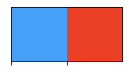

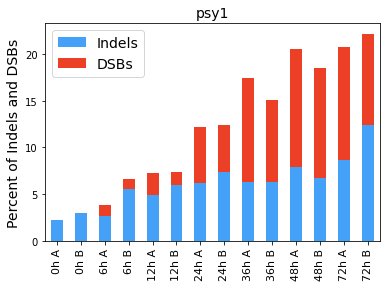

In [30]:
#drop columns for Intact and Total, and calculate averages
percent_states_df_plot = percent_states_df.drop(percent_states_df.index[[-1,0]])
average_state_sum = Calculate_average(percent_states_df_plot)

colors = [
'#44a1f7','#eb4025']

sns.set_palette(sns.color_palette(colors))
current_palette = sns.color_palette(colors)
sns.palplot(current_palette)
my_cmap = ListedColormap(sns.color_palette(colors).as_hex())


labels=['0h A','0h B','6h A','6h B','12h A','12h B','24h A','24h B','36h A','36h B','48h A','48h B','72h A','72h B']
fig = percent_states_df_plot.T.plot(kind='bar', stacked=True, cmap = my_cmap)
plt.gca().legend(['Indels','DSBs'],loc='upper left',ncol = 1, fontsize=14)
plt.title(target_name,fontsize=14)
plt.xlabel('')
plt.ylabel('Percent of Indels and DSBs',fontsize=14)
fig.set_xticklabels(labels, fontsize=11)
plt.savefig(save_dir+target_name+'_states_barplot.pdf', bbox_inches='tight')

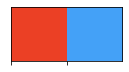

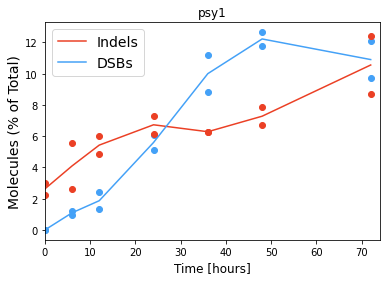

In [32]:
colors = [
'#eb4025','#44a1f7']

sns.set_palette(sns.color_palette(colors))
current_palette = sns.color_palette(colors)
sns.palplot(current_palette)
my_cmap = ListedColormap(sns.color_palette(colors).as_hex())

percent_states_df_time = percent_states_df_plot.T
percent_states_df_time['time']=[0,0,6,6,12,12,24,24,36,36,48,48,72,72]
NHEJ = percent_states_df_time['NHEJ']
DSB = percent_states_df_time['Putative DSB']
time = percent_states_df_time['time']
NHEJ
plt.figure(figsize=(6, 4))
plt.plot(average_state_sum)
plt.plot(time, NHEJ,'o', color='#44a1f7')
plt.plot(time,DSB, 'o', color='#eb4025')
plt.gca().legend(['Indels','DSBs'],loc='upper left',ncol = 1, fontsize=14)
plt.title(target_name)
plt.xlim(0,74)
plt.xlabel('Time [hours]', fontsize=12)
plt.ylabel('Molecules (% of Total)',fontsize=14)
plt.savefig(save_dir+target_name+'_states_dot_averageLine.pdf', bbox_inches='tight')